In [2]:
%pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/MyDrive/cs4248")

In [5]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import json
import re
import torch
from torch import nn
from collections import defaultdict
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses, models, evaluation
from sentence_transformers.evaluation import TripletEvaluator
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [10]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Device: mps")
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Device: cuda")
else:
    device = torch.device('cpu')
    print("Device: cpu")

Device: cuda


In [17]:
file_path_train = 'scicite/train.jsonl'
file_path_dev = 'scicite/dev.jsonl'
file_path_test = 'scicite/test.jsonl'
train_data = []
dev_data = []
test_data = []
with open(file_path_train, 'r', encoding='utf-8') as file:
    for line in file:
        train_data.append(json.loads(line))
with open(file_path_dev, 'r', encoding='utf-8') as file:
    for line in file:
        dev_data.append(json.loads(line))
with open(file_path_test, 'r', encoding='utf-8') as file:
    for line in file:
        test_data.append(json.loads(line))
print("Sample data points:")
print(train_data[0])
print(train_data[1])
print(train_data[2])
print("Keys:", list(train_data[0].keys()))
print("Number of training data points:", len(train_data))
print("Label distribution:", {x['label']: sum([1 for y in train_data if y['label'] == x['label']]) for x in train_data[:100]})

Sample data points:
{'source': 'explicit', 'citeEnd': 175, 'sectionName': 'Introduction', 'citeStart': 168, 'string': 'However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).', 'label': 'background', 'label_confidence': 1.0, 'citingPaperId': '1872080baa7d30ec8fb87be9a65358cd3a7fb649', 'citedPaperId': '894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'isKeyCitation': True, 'id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0', 'unique_id': '1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be9b4ea46a5c422e81ef3c241072d4c73fdc0_11', 'excerpt_index': 11}
{'source': 'explicit', 'citeStart': 16, 'sectionName': 'Novel Quantitative Trait Loci for Seminal Root Traits in Barley', 'string': 'In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological\nrobinson et al.

In [ ]:
for data_point in train_data[:10]:
    print("Citation Text:", data_point['string'])
    print("Label:", data_point['label'])
    print("Label Confidence:", data_point['label_confidence'])

Citation Text: However, how frataxin interacts with the Fe-S cluster biosynthesis components remains unclear as direct one-to-one interactions with each component were reported (IscS [12,22], IscU/Isu1 [6,11,16] or ISD11/Isd11 [14,15]).
Label: background
Label Confidence: 1.0
Citation Text: In the study by Hickey et al. (2012), spikes were sampled from the field at the point of physiological
robinson et al.: genomic regions influencing root traits in barley 11 of 13
maturity, dried, grain threshed by hand, and stored at −20C to preserve grain dormancy before germination testing.
Label: background
Label Confidence: 1.0
Citation Text: The drug also reduces catecholamine secretion, thereby reducing stress and leading to a modest (10-20%) reduction in heart rate and blood pressure, which may be particularly beneficial in patients with cardiovascular disease.(7) Unlike midazolam, dexmedetomidine does not affect the ventilatory response to carbon dioxide.
Label: background
Label Confidence: 

In [ ]:
# Use SciBERT for mapping text to embeddings
model_name = 'allenai/scibert_scivocab_uncased'
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [6]:
class CitationsDataset:
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return InputExample(guid=item, texts=[self.data[item]['string']], label=CitationsDataset.label_to_id[self.data[item]['label']])

In [7]:
# Parameters
train_batch_size = 16
dev_batch_size = train_batch_size
test_batch_size = train_batch_size
num_epochs = 5

In [ ]:
train_dataset = CitationsDataset(train_data)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

In [ ]:
def triplets_from_labeled_dataset(input_examples):
    # Create triplets for a [(label, sentence), (label, sentence)...] dataset
    # by using each example as an anchor and selecting randomly a
    # positive instance with the same label and a negative instance with a different label
    triplets = []
    label2sentence = defaultdict(list)
    for inp_example in input_examples:
        label2sentence[inp_example.label].append(inp_example)

    for inp_example in input_examples:
        anchor = inp_example

        if len(label2sentence[inp_example.label]) < 2:  # We need at least 2 examples per label to create a triplet
            continue

        positive = None
        while positive is None or positive.guid == anchor.guid:
            positive = random.choice(label2sentence[inp_example.label])

        negative = None
        while negative is None or negative.label == anchor.label:
            negative = random.choice(input_examples)

        triplets.append(InputExample(texts=[anchor.texts[0], positive.texts[0], negative.texts[0]]))

    return triplets

In [ ]:
dev_dataset = CitationsDataset(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)
dev_triplets = triplets_from_labeled_dataset(dev_dataset)

In [ ]:
train_loss = losses.BatchAllTripletLoss(model=model)
dev_evaluator = TripletEvaluator.from_input_examples(dev_triplets, name="scibert-dev-triplets")
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=dev_evaluator,
    epochs=num_epochs,
    evaluation_steps=1000,
    warmup_steps=warmup_steps,
    output_path='output/pre_trained_scibert-scicite-best'
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

Iteration:   0%|          | 0/516 [00:00<?, ?it/s]

In [ ]:
# Sanity check pretraining results
model = SentenceTransformer('output/pre_trained_scibert-scicite-best')

sentences = [
    "This framework generates embeddings for each input sentence",
    "Sentences are passed as a list of strings.",
    "The quick brown fox jumps over the lazy dog.",
]

embeddings = model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding Length:", len(embedding))
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding Length: 768
Embedding: [ 7.71528602e-01 -5.95570028e-01  7.93987632e-01  5.53109288e-01
  2.21674651e-01 -1.44604623e+00  3.17543633e-02  2.04439208e-01
 -7.89382279e-01  1.06419012e-01  3.41694891e-01  1.27980158e-01
 -3.81732851e-01  2.60198917e-02 -5.37950516e-01 -3.23042452e-01
  2.68266737e-01  3.94458294e-01  9.95119691e-01  1.10098433e+00
 -2.58792102e-01 -8.15216422e-01 -2.84147054e-01 -2.30123639e-01
  1.55741560e+00  1.16781330e+00  2.45238662e-01  1.03550410e+00
 -7.81940877e-01 -6.10823929e-01 -3.17277871e-02 -5.62164903e-01
 -6.05922826e-02 -2.60906309e-01  3.86831462e-02  3.38244945e-01
 -1.58343032e-01 -6.41424119e-01 -9.58261311e-01  4.21900272e-01
 -1.45350872e-02  2.73947269e-01  8.96530986e-01  3.68862338e-02
  5.26286602e-01  1.57781208e+00  1.00456035e+00  3.09518695e-01
 -9.27853227e-01 -2.93704033e-01  7.22966492e-01 -1.44540906e+00
  9.98839885e-02  3.47699374e-02  8.14116001e-02  4.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
def visualize_embeddings(embeddings, true_labels, method='PCA', perplexity=None):
    if method == 'PCA':
        pca = PCA(n_components=2)
        transformed = pca.fit_transform(embeddings)
        print(str(pca.explained_variance_ratio_.sum() * 100) + "% variance explained using PCA")
    elif method == 't-SNE':
        if perplexity is not None:
          tsne = TSNE(n_components=2, perplexity=perplexity)
        else:
          tsne = TSNE(n_components=2)
        transformed = tsne.fit_transform(embeddings)
    fig = px.scatter(x=transformed[:, 0], y=transformed[:, 1], color=true_labels)
    fig.update_layout(
        title="Visualization after Dimension Reduction",
        xaxis_title="Dimension_1",
        yaxis_title="Dimension_2",
    )
    fig.show()

In [ ]:
test_sentences = [data_point['string'] for data_point in test_data]
test_embeddings = np.array(model.encode(test_sentences))

In [ ]:
test_labels = np.array([data_point['label'] for data_point in test_data])

In [ ]:
test_embeddings.shape, test_labels.reshape(-1, 1).shape

((1861, 768), (1861, 1))

In [ ]:
visualize_embeddings(test_embeddings, test_labels, method='PCA')

61.49364113807678% variance explained using PCA


In [8]:
class CitationIntentClassifier(nn.Module):
    def __init__(self, model_path, num_labels):
        super(CitationIntentClassifier, self).__init__()
        self.sentence_transformer = SentenceTransformer(model_path)
        self.classifier = nn.Linear(self.sentence_transformer.get_sentence_embedding_dimension(), num_labels)

    def forward(self, input_texts):
        embeddings = self.sentence_transformer.encode(input_texts, convert_to_tensor=True)
        return self.classifier(embeddings)

In [11]:
model_path = 'output/pre_trained_scibert-scicite-best'
num_labels = len(CitationsDataset.label_to_id)
citation_intent_classifier = CitationIntentClassifier(model_path, num_labels).to(device)

In [12]:
# Parameters
learning_rate = 2e-5
num_epochs = 5

In [13]:
optimizer = torch.optim.Adam(citation_intent_classifier.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

In [14]:
class CitationsDatasetWithoutInputExample():
    label_to_id = {'background': 0, 'method': 1, 'result': 2}
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]['string'], CitationsDatasetWithoutInputExample.label_to_id[self.data[item]['label']]

In [18]:
train_dataset = CitationsDatasetWithoutInputExample(train_data)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

In [19]:
dev_dataset = CitationsDatasetWithoutInputExample(dev_data)
dev_dataloader = DataLoader(dev_dataset, shuffle=False, batch_size=dev_batch_size)

In [20]:
def train_epoch(model, dataloader, loss_func, optimizer):
    model.train()
    total_loss = 0
    for input_texts, labels in dataloader:
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(input_texts)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Training loss: {total_loss / len(dataloader)}")

def evaluate(model, dataloader, loss_func):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            loss = loss_func(output, labels)
            total_loss += loss.item()
            total_correct += (output.argmax(1) == labels).sum().item()
    print(f"Evaluation loss: {total_loss / len(dataloader)}")
    print(f"Evaluation accuracy: {total_correct / len(dataloader.dataset)}")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_epoch(citation_intent_classifier, train_dataloader, loss_func, optimizer)
    evaluate(citation_intent_classifier, dev_dataloader, loss_func)

Epoch 1/5
Training loss: 0.64951622104922
Evaluation loss: 0.4814428240060806
Evaluation accuracy: 0.8449781659388647
Epoch 2/5
Training loss: 0.3576715151930964
Evaluation loss: 0.42019651907271355
Evaluation accuracy: 0.851528384279476
Epoch 3/5
Training loss: 0.31160704495544117
Evaluation loss: 0.4132433633865981
Evaluation accuracy: 0.851528384279476
Epoch 4/5
Training loss: 0.29655113983754966
Evaluation loss: 0.4138444709623682
Evaluation accuracy: 0.8504366812227074
Epoch 5/5
Training loss: 0.28967663827677104
Evaluation loss: 0.4159359102105272
Evaluation accuracy: 0.8493449781659389


In [21]:
test_dataset = CitationsDatasetWithoutInputExample(test_data)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_batch_size)

In [22]:
def test(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for input_texts, labels in dataloader:
            labels = labels.to(device)
            output = model(input_texts)
            _, predicted_labels = torch.max(output, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(torch.softmax(output, dim=1).cpu().numpy())
    return predictions, true_labels, probabilities

predictions, true_labels, probabilities = test(citation_intent_classifier, test_dataloader, device)

ROC-AUC score for Background: 0.9425759918644823
ROC-AUC score for Method: 0.9548461599199873
ROC-AUC score for Result: 0.9816566164880772


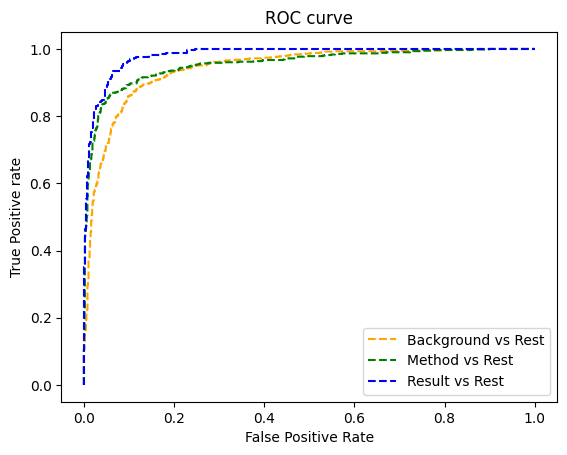

In [23]:
# AUC-ROC curve
fpr = {}
tpr = {}
num_classes = 3

index_to_label = {0: 'Background', 1: 'Method', 2: 'Result'}

for i in range(num_classes):
    class_probs = [prob[i] for prob in probabilities]
    score = roc_auc_score((np.array(true_labels) == i).astype(int), class_probs, multi_class='ovr')
    print(f'ROC-AUC score for {index_to_label[i]}: {score}')
    fpr[i], tpr[i], _ = roc_curve(true_labels, class_probs, pos_label=i)

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Background vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Method vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Result vs Rest')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC-scicite',dpi=300);

In [24]:
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1}")

F1 Score: 0.8494076461744343


In [ ]:
torch.save(citation_intent_classifier.state_dict(), 'output/citation_intent_classifier.pth')